# Импортируем библиотеки

In [22]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.model_selection import train_test_split

import lightgbm as lgbm
import xgboost as xgb
import catboost

# Загружаем датасеты

In [23]:
# Загружаем данные

train_data = pd.read_csv('data/train_processed.csv')
valid_data = pd.read_csv('data/valid_processed.csv')

# Подготавливаем данные для обучения моделей

In [24]:
# Разделяем датасеты на выборки

# Чиним заголовки, иначе LightGBM ругается
train_data = train_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
valid_data = valid_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# Разделяем train датасет на таргет и признаки
X_train = train_data.drop(columns=['target'])  # Признаки
y_train = train_data['target']  # Таргет

# Разделяем valid датасет на таргет и признаки
X_valid = valid_data.drop(columns=['target']) # Признаки
y_valid = valid_data['target'] # Таргет

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Балансировка данных с помощью SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Функция вывода метрик модели

In [25]:
def print_metrics(model, model_name):
    
    # test выборка
    test_predictions = model.predict(X_test)
    test_probabilities = model.predict_proba(X_test)[:, 1]

    test_accuracy = accuracy_score(y_test, test_predictions)
    test_presicion = precision_score(y_test, test_predictions)
    test_recall = recall_score(y_test, test_predictions)
    test_f1score = f1_score(y_test, test_predictions)
    test_roc_auc = roc_auc_score(y_test, test_probabilities)

    # valid выборка
    valid_predictions = model.predict(X_valid)
    valid_probabilities = model.predict_proba(X_valid)[:, 1]

    valid_accuracy = accuracy_score(y_valid, valid_predictions)
    valid_presicion = precision_score(y_valid, valid_predictions)
    valid_recall = recall_score(y_valid, valid_predictions)
    valid_f1score = f1_score(y_valid, valid_predictions)
    valid_roc_auc = roc_auc_score(y_valid, valid_probabilities)

    # Submission
    submission_valid = pd.DataFrame({'client_id': valid_data.loc[X_valid.index, 'client_id'], 'score': valid_probabilities})
    submission_valid.to_csv('submissions/' + model_name + '_submission.csv', index=False)

    # Выводим метрики
    print(f"""\nТест на тестовой выборке
    Accuracy: {test_accuracy:.4f}
    Precision: {test_presicion:.4f}
    Recall: {test_recall:.4f}
    F1-Score: {test_f1score:.4f}
    ROC-AUC: {test_roc_auc:.4f}\n
    """)

    print(f"""Тест на валидационной выборке
    Accuracy: {valid_accuracy:.4f}
    Precision: {valid_presicion:.4f}
    Recall: {valid_recall:.4f}
    F1-Score: {valid_f1score:.4f}
    ROC-AUC: {valid_roc_auc:.4f}
    """)

    # ROC-кривая для test
    fpr, tpr, thresholds = roc_curve(y_test, test_probabilities)
    ROC_test = roc_auc_score(y_test, test_probabilities)

    # ROC-кривая для valid
    fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, valid_probabilities)
    ROC_valid = roc_auc_score(y_valid, valid_probabilities)

    plt.figure(figsize=(10, 6))

    # Вывод test
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {ROC_test:.2f}) on Test and ')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Диагональная линия
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) on ' + model_name)
    plt.legend(loc="lower right")
    plt.grid(True)

    # Вывод valid
    plt.plot(fpr_valid, tpr_valid, color='red', lw=2, label=f'ROC curve (area = {ROC_valid:.2f}) on Valid')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Диагональная линия
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) on ' + model_name)
    plt.legend(loc="lower right")
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    return valid_probabilities, 

# LightGBM

In [26]:
# Обучаем модель
lgbm_model = lgbm.LGBMClassifier(
    num_leaves=40,
    n_estimators=300,
    random_state=42
)
lgbm_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 11211, number of negative: 11211
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33850
[LightGBM] [Info] Number of data points in the train set: 22422, number of used features: 153
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(n_estimators=300, num_leaves=40, random_state=42)


Тест на тестовой выборке
    Accuracy: 0.9869
    Precision: 0.8169
    Recall: 0.6988
    F1-Score: 0.7532
    ROC-AUC: 0.9740

    
Тест на валидационной выборке
    Accuracy: 0.9830
    Precision: 1.0000
    Recall: 0.0606
    F1-Score: 0.1143
    ROC-AUC: 0.7368
    


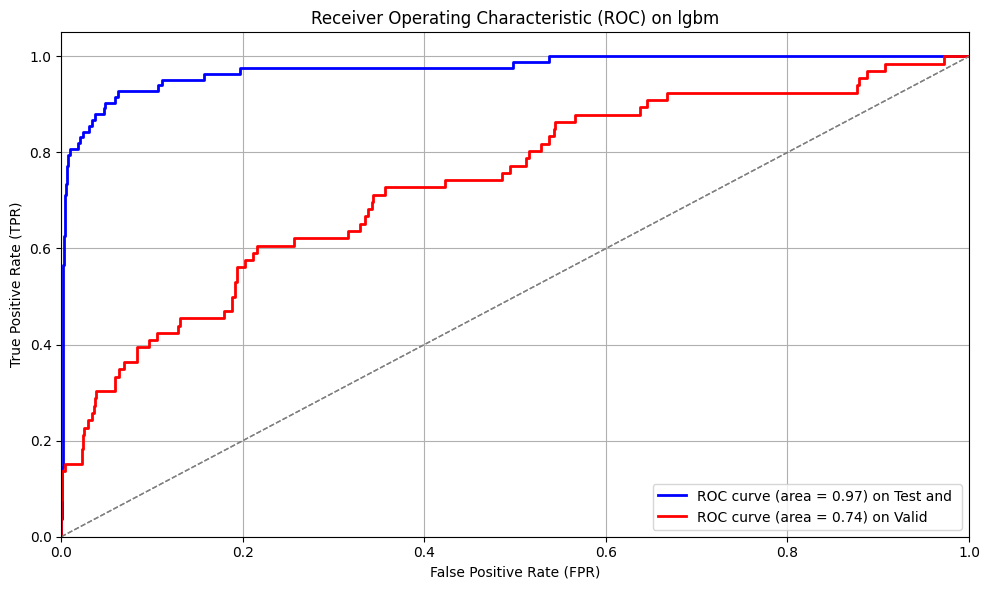

In [27]:
# Выводим метрики по LightGBM
lgbm_model_metric = print_metrics(lgbm_model, 'lgbm')

# XGBoost

In [28]:
xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=30,
    subsample=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)


Тест на тестовой выборке
    Accuracy: 0.9865
    Precision: 0.8235
    Recall: 0.6747
    F1-Score: 0.7417
    ROC-AUC: 0.9726

    
Тест на валидационной выборке
    Accuracy: 0.9822
    Precision: 0.5556
    Recall: 0.0758
    F1-Score: 0.1333
    ROC-AUC: 0.7348
    


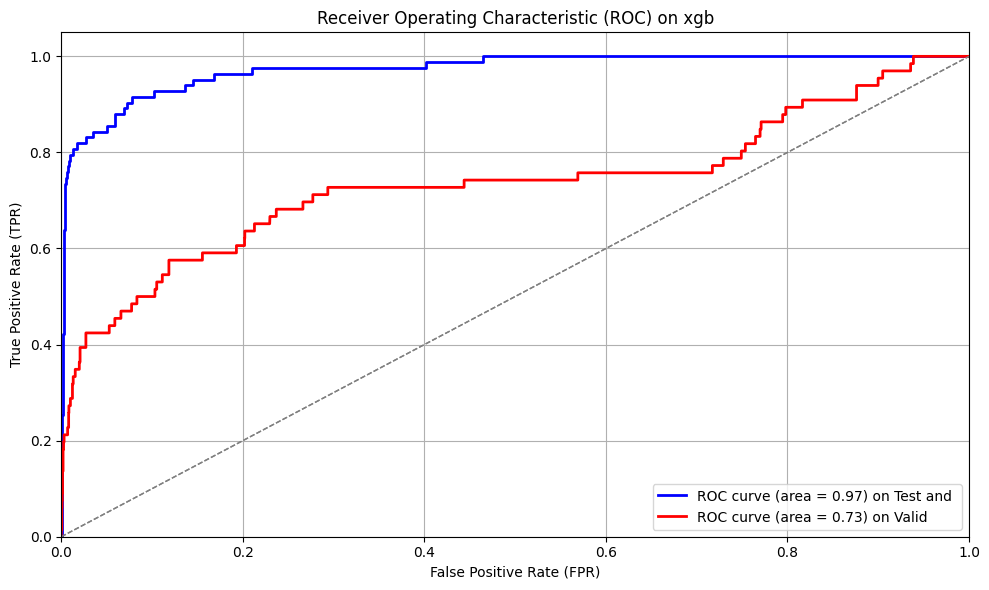

In [29]:
xgb_model_metric = print_metrics(xgb_model, 'xgb')

# CatBoost

In [30]:
catboost_model = catboost.CatBoostClassifier(
    iterations=500,           # Количество итераций
    depth=8,                  # Глубина деревьев
    random_state=42
)
catboost_model.fit(X_train, y_train)
catboost_model_metric = print_metrics(catboost_model, 'catboost')

Learning rate set to 0.073403
0:	learn: 0.6107106	total: 94.9ms	remaining: 47.4s
1:	learn: 0.5361734	total: 194ms	remaining: 48.3s
2:	learn: 0.4907422	total: 278ms	remaining: 46s
3:	learn: 0.4523990	total: 387ms	remaining: 48s
4:	learn: 0.4163704	total: 487ms	remaining: 48.3s
5:	learn: 0.3856690	total: 589ms	remaining: 48.5s
6:	learn: 0.3598513	total: 672ms	remaining: 47.3s
7:	learn: 0.3368253	total: 748ms	remaining: 46s
8:	learn: 0.3192882	total: 833ms	remaining: 45.5s
9:	learn: 0.3033635	total: 928ms	remaining: 45.5s
10:	learn: 0.2920815	total: 1.02s	remaining: 45.4s
11:	learn: 0.2782000	total: 1.1s	remaining: 45s
12:	learn: 0.2657979	total: 1.18s	remaining: 44.4s
13:	learn: 0.2557086	total: 1.26s	remaining: 43.9s
14:	learn: 0.2499221	total: 1.35s	remaining: 43.6s
15:	learn: 0.2410623	total: 1.42s	remaining: 43.1s
16:	learn: 0.2342151	total: 1.5s	remaining: 42.7s
17:	learn: 0.2282555	total: 1.59s	remaining: 42.6s
18:	learn: 0.2225992	total: 1.67s	remaining: 42.3s
19:	learn: 0.2179119


Тест на тестовой выборке
    Accuracy: 0.9858
    Precision: 0.8088
    Recall: 0.6627
    F1-Score: 0.7285
    ROC-AUC: 0.9727

    
Тест на валидационной выборке
    Accuracy: 0.9813
    Precision: 0.3333
    Recall: 0.0303
    F1-Score: 0.0556
    ROC-AUC: 0.7897
    


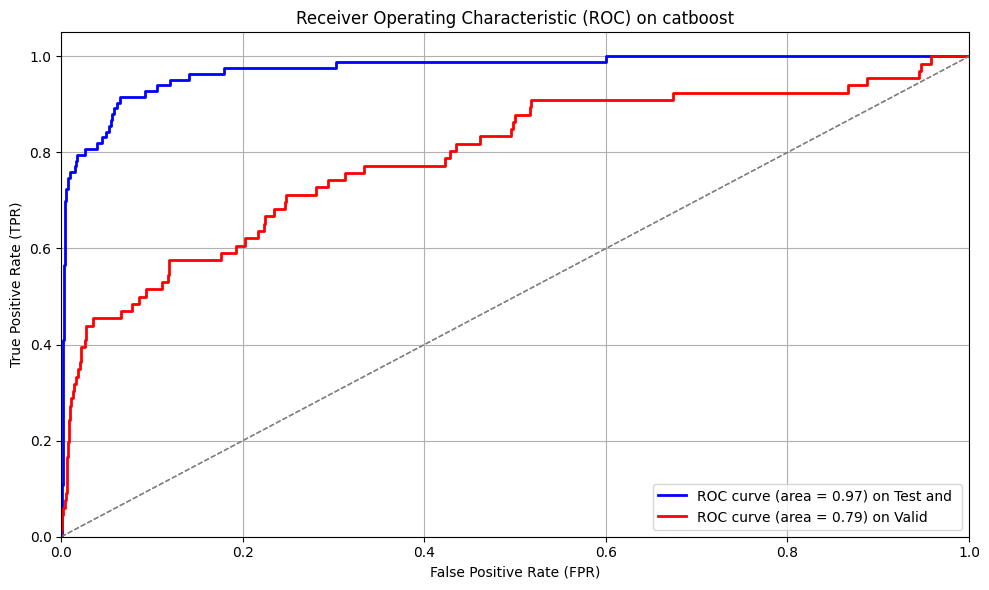

# Random Forest

In [32]:
random_forest_model = RandomForestClassifier(
    random_state=42
)
random_forest_model.fit(X_train, y_train)
random_forest_model_model_metric = print_metrics(random_forest_model, 'random_forest')

RandomForestClassifier(random_state=42)